In [1]:
from data import *
import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
train_labels

[5,
 0,
 4,
 1,
 9,
 2,
 1,
 3,
 1,
 4,
 3,
 5,
 3,
 6,
 1,
 7,
 2,
 8,
 6,
 9,
 4,
 0,
 9,
 1,
 1,
 2,
 4,
 3,
 2,
 7,
 3,
 8,
 6,
 9,
 0,
 5,
 6,
 0,
 7,
 6,
 1,
 8,
 7,
 9,
 3,
 9,
 8,
 5,
 9,
 3,
 3,
 0,
 7,
 4,
 9,
 8,
 0,
 9,
 4,
 1,
 4,
 4,
 6,
 0,
 4,
 5,
 6,
 1,
 0,
 0,
 1,
 7,
 1,
 6,
 3,
 0,
 2,
 1,
 1,
 7,
 9,
 0,
 2,
 6,
 7,
 8,
 3,
 9,
 0,
 4,
 6,
 7,
 4,
 6,
 8,
 0,
 7,
 8,
 3,
 1,
 5,
 7,
 1,
 7,
 1,
 1,
 6,
 3,
 0,
 2,
 9,
 3,
 1,
 1,
 0,
 4,
 9,
 2,
 0,
 0,
 2,
 0,
 2,
 7,
 1,
 8,
 6,
 4,
 1,
 6,
 3,
 4,
 5,
 9,
 1,
 3,
 3,
 8,
 5,
 4,
 7,
 7,
 4,
 2,
 8,
 5,
 8,
 6,
 7,
 3,
 4,
 6,
 1,
 9,
 9,
 6,
 0,
 3,
 7,
 2,
 8,
 2,
 9,
 4,
 4,
 6,
 4,
 9,
 7,
 0,
 9,
 2,
 9,
 5,
 1,
 5,
 9,
 1,
 2,
 3,
 2,
 3,
 5,
 9,
 1,
 7,
 6,
 2,
 8,
 2,
 2,
 5,
 0,
 7,
 4,
 9,
 7,
 8,
 3,
 2,
 1,
 1,
 8,
 3,
 6,
 1,
 0,
 3,
 1,
 0,
 0,
 1,
 7,
 2,
 7,
 3,
 0,
 4,
 6,
 5,
 2,
 6,
 4,
 7,
 1,
 8,
 9,
 9,
 3,
 0,
 7,
 1,
 0,
 2,
 0,
 3,
 5,
 4,
 6,
 5,
 8,
 6,
 3,
 7,
 5,
 8,
 0,
 9,
 1,
 0,


In [3]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [10]:
train_data = np.asarray(train_images).reshape([len(train_images), 28, 28]) / 256
test_data = np.asarray(test_images).reshape([len(test_images), 28, 28]) / 256
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=100,
    hooks=[logging_hook])
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": test_data},
    y=test_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_is_chief': True, '_save_checkpoints_steps': None, '_model_dir': '/tmp/mnist_convnet_model', '_service': None, '_train_distribute': None, '_session_config': None, '_num_ps_replicas': 0, '_global_id_in_cluster': 0, '_num_worker_replicas': 1, '_master': '', '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_evaluation_master': '', '_tf_random_seed': None, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_task_type': 'worker', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efdf105d940>}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-9719
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorf

INFO:tensorflow:loss = 0.18437065184116364, step = 9720
INFO:tensorflow:probabilities = [[0.00000034 0.00004139 0.00384328 0.99609003 0.00000004 0.00001289
  0.00000009 0.00000085 0.00001044 0.00000065]
 [0.00000009 0.00021069 0.01058868 0.0095666  0.00007752 0.00003415
  0.0000001  0.97915773 0.00005328 0.00031115]
 [0.00018699 0.00001887 0.00001138 0.00501201 0.00526547 0.02128322
  0.00002408 0.83647598 0.00763085 0.12409115]
 [0.00000023 0.00000374 0.99996479 0.00000839 0.00000109 0.00000015
  0.00000631 0.00000002 0.00001521 0.00000005]
 [0.94911857 0.00000006 0.02347274 0.00119402 0.00000138 0.00245743
  0.01776336 0.0000499  0.00555816 0.00038439]
 [0.00026669 0.00000049 0.00001053 0.00003397 0.01574741 0.00064714
  0.00000878 0.04208599 0.00430103 0.93689796]
 [0.002775   0.00003379 0.00059567 0.00100254 0.22222555 0.00208574
  0.00026302 0.00886326 0.00431284 0.75784259]
 [0.00000796 0.00001587 0.00045383 0.00000683 0.00014016 0.00017021
  0.99825949 0.00000002 0.00094107 0.00

INFO:tensorflow:Saving checkpoints for 9819 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.27351149916648865.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-07-16:02:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-9819
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-07-16:02:56
INFO:tensorflow:Saving dict for global step 9819: accuracy = 0.9493, global_step = 9819, loss = 0.17162888
{'loss': 0.17162888, 'global_step': 9819, 'accuracy': 0.9493}


In [13]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [17]:
mnist.train.next_batch(100)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([9, 1, 7, 5, 2, 9, 5, 1, 0, 5, 5, 6, 0, 3, 2, 6, 5, 0, 1, 0, 8, 1,
        3, 0, 0, 9, 0, 7, 0, 2, 6, 6, 1, 8, 6, 2, 7, 5, 3, 9, 3, 1, 7, 0,
        0, 9, 9, 3, 9, 5, 4, 4, 3, 8, 8, 8, 1, 2, 8, 0, 9, 8, 8, 7, 7, 1,
        0, 1, 0, 3, 0, 6, 9, 6, 2, 1, 1, 0, 4, 1, 0, 9, 3, 7, 4, 9, 5, 5,
        0, 1, 5, 2, 0, 3, 9, 4, 1, 8, 0, 4], dtype=uint8))

In [12]:
import os
os.system("/login.sh")

0

In [18]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [22]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In [20]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    n_samples = len(train_images)
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            batch_xs = np.asarray(train_images[i:i + batch_size], dtype=np.float32) / 256

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

In [23]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=75)

Epoch: 0001 cost= 181.990041656
Epoch: 0006 cost= 111.249161212
Epoch: 0011 cost= 106.277914429
Epoch: 0016 cost= 103.664382248
Epoch: 0021 cost= 102.270044022
Epoch: 0026 cost= 101.199121132
Epoch: 0031 cost= 100.361563352
Epoch: 0036 cost= 99.700084546
Epoch: 0041 cost= 99.147791506
Epoch: 0046 cost= 98.657768110
Epoch: 0051 cost= 98.185876376
Epoch: 0056 cost= 97.808938014
Epoch: 0061 cost= 97.511728210
Epoch: 0066 cost= 97.194660606
Epoch: 0071 cost= 96.944334081


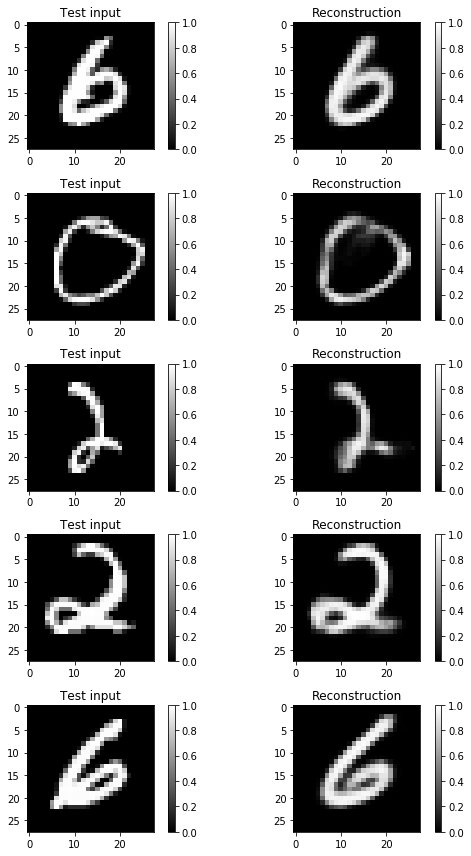

In [26]:
import matplotlib.pyplot as plt

x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()
plt.show()

In [28]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()
plt.show()

ValueError: Cannot feed value of shape (100, 2) for Tensor 'Add_8:0', which has shape '(100, 20)'

In [47]:
network_architecturenetwork  = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecturenetwork, training_epochs=75)

/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 190.305849228
Epoch: 0006 cost= 155.004807866
Epoch: 0011 cost= 149.584628143
Epoch: 0016 cost= 146.963884150
Epoch: 0021 cost= 145.360751190
Epoch: 0026 cost= 144.242702115
Epoch: 0031 cost= 143.370714531
Epoch: 0036 cost= 142.639979350
Epoch: 0041 cost= 142.083574092
Epoch: 0046 cost= 141.667766800
Epoch: 0051 cost= 141.210090853
Epoch: 0056 cost= 140.906493937
Epoch: 0061 cost= 140.544401271
Epoch: 0066 cost= 140.192757161
Epoch: 0071 cost= 139.948085251


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1000, 20)


<Figure size 432x288 with 0 Axes>

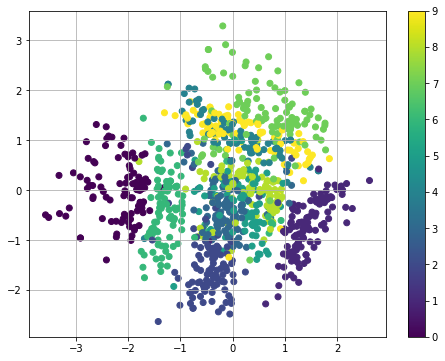

In [58]:
x_sample, y_sample = mnist.test.next_batch(1000)
print(x_sample.shape)
z_mu = vae_2d.transform(x_sample)
print(x_sample)
print(vae.transform(x_sample))

plt.clf()
plt.figure(figsize=(8, 6))
# print(z_mu[:,0], z_mu[:,1])
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_sample)
plt.colorbar()
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

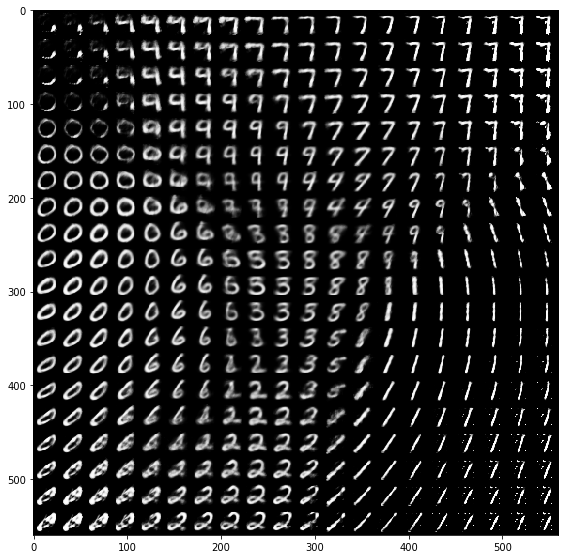

In [48]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
#         print(vae_2d.network_architecture["n_z"])
#         print(z_mu)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.clf()
plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:
x_sample, y_sample = mnist.test.next_batch(1000)
z_mu = vae_2d.transform(x_sample)
print(x_sample)
print(vae.transform(x_sample))

plt.clf()
plt.figure(figsize=(8, 6))
# print(z_mu[:,0], z_mu[:,1])
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_sample)
plt.colorbar()
plt.grid()
plt.show()

In [73]:
from sklearn import svm

x_sample, y_sample = np.asarray(train_images[:10000]) / 256, train_labels[:10000]
x_test, y_test = np.asarray(test_images[:300]) / 256, test_labels[:300]
z_mu = vae.transform(x_sample)

clf = svm.SVC()
clf.fit(z_mu, y_sample)
print(clf.score(vae.transform(x_test), y_test))

0.9766666666666667


In [66]:
x_sample, y_sample = mnist.test.next_batch(1000)
print(x_sample, y_sample)

(1000, 784)


In [74]:
from sklearn import svm

x_sample, y_sample = np.asarray(train_images[:10000]) / 256, train_labels[:10000]
x_test, y_test = np.asarray(test_images[:300]) / 256, test_labels[:300]
z_mu = vae_2d.transform(x_sample)

clf = svm.SVC()
clf.fit(z_mu, y_sample)
print(clf.score(vae_2d.transform(x_test), y_test))

0.6866666666666666


In [75]:
from sklearn import svm

x_sample, y_sample = np.asarray(train_images[:10000]) / 256, train_labels[:10000]
x_test, y_test = np.asarray(test_images) / 256, test_labels
z_mu = vae.transform(x_sample)

clf = svm.SVC()
clf.fit(z_mu, y_sample)
print(clf.score(vae.transform(x_test), y_test))

0.9652


In [2]:
print 1

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-2-c94594b6b28f>, line 1)

In [77]:
import numpy as np
import tensorflow as tf
from data import *


tf.logging.set_verbosity(tf.logging.INFO)


def xavier_init(fan_in, fan_out, constant=1):
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out),
                             minval=low, maxval=high,
                             dtype=tf.float32)


class CNNVariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.

    This implementation uses probabilistic encoders and decoders using Gaussian
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.

    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """

    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus,
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])

        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and
        # corresponding optimizer
        self._create_loss_optimizer()

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        writer = tf.summary.FileWriter('.')
        writer.add_graph(tf.get_default_graph())

    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and
        # (log) variance of Gaussian distribution in latent
        # space
        self._recognition_network()

        # Draw one sample z from Gaussian distribution
        eps = tf.random_normal((self.batch_size, self.n_z), 0, 1,
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean,
                        tf.multiply(tf.exp(self.z_log_sigma_sq / 2), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self._generator_network()

    def _initialize_weights(self, n_z, **kwargs):
        self.n_z = n_z

    def _recognition_network(self):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        self.input_layer = tf.reshape(self.x, [-1, 28, 28, 1])
        self.conv1 = tf.layers.conv2d(
            inputs=self.input_layer,
            filters=32,
            kernel_size=[10, 10],
            padding="valid",
            activation=tf.nn.relu
        )
        self.conv2 = tf.layers.conv2d(
            inputs=self.conv1,
            filters=64,
            kernel_size=[10, 10],
            padding="valid",
            activation=tf.nn.relu
        )
        self.conv2_flat = tf.reshape(self.conv2, [-1, 10 * 10 * 64])
        self.dense1 = tf.layers.dense(
            inputs=self.conv2_flat,
            units=1024,
            activation=tf.nn.relu
        )
        self.z_mean = tf.layers.dense(
            inputs=self.dense1,
            units=self.n_z,
            activation=tf.nn.relu
        )
        self.z_log_sigma_sq = tf.layers.dense(
            inputs=self.dense1,
            units=self.n_z,
            activation=tf.nn.relu
        )

    # def _sample_z(self):
    #     noise = tf.random_normal(shape=(self.batch_size, self.n_z), mean=0., std=1.)
    #     return tf.add(self.z_mean, tf.matmul(tf.exp(self.z_log_sigma_sq / 2) * noise))

    def _generator_network(self):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.

        self.dense3 = tf.layers.dense(
            inputs=self.z,
            units=10 * 10 * 64,
            activation=tf.nn.relu
        )
        self.dense2_reshape = tf.reshape(self.dense3, [-1, 10, 10, 64])
        self.dconv1 = tf.layers.conv2d_transpose(
            inputs=self.dense2_reshape,
            filters=32,
            kernel_size=[10, 10],
            padding="valid",
            activation=tf.nn.relu)
        self.dconv2 = tf.layers.conv2d_transpose(
            inputs=self.dconv1,
            filters=1,
            kernel_size=[10, 10],
            padding="valid",
            activation=tf.nn.relu)
        self.x_reconstr_mean = tf.reshape(self.dconv2, [-1, 784])

    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1 - self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence
        ##    between the distribution in latent space induced by the encoder on
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq
                                           - tf.square(self.z_mean)
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)  # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, X):
        """Train model based on mini-batch of input data.

        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost),
                                  feed_dict={self.x: X})
        return cost

    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.

        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu})

    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X})


def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = CNNVariationalAutoencoder(network_architecture,
                                 learning_rate=learning_rate,
                                 batch_size=batch_size)
    # Training cycle
    n_samples = len(train_images)
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            batch_xs = np.asarray(train_images[i:i + batch_size], dtype=np.float32) / 256

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(avg_cost))
    return vae


network_architecture = {
    "n_input": 784, # MNIST data input (img shape: 28*28)
    "n_z": 2, # dimensionality of latent space
}

vae = train(network_architecture, training_epochs=75)

/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= nan


KeyboardInterrupt: 

In [ ]:
import os
CPU_Pct=str(round(float(os.popen('''grep 'cpu ' /proc/stat | awk '{usage=($2+$4)*100/($2+$4+$5)} END {print usage }' ''').readline()),2))
print(CPU_Pct)

In [83]:
import numpy as np
import tensorflow as tf
from data import *


tf.logging.set_verbosity(tf.logging.INFO)


class CNNVariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.

    This implementation uses probabilistic encoders and decoders using Gaussian
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.

    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """

    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus,
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])

        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and
        # corresponding optimizer
        self._create_loss_optimizer()

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)

    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and
        # (log) variance of Gaussian distribution in latent
        # space
        self._recognition_network()

        # Draw one sample z from Gaussian distribution
        eps = tf.random_normal((self.batch_size, self.n_z), 0, 1,
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean,
                        tf.multiply(tf.exp(self.z_log_sigma_sq / 2), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self._generator_network()

    def _initialize_weights(self, n_z, **kwargs):
        self.n_z = n_z

    def _recognition_network(self):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        self.input_layer = tf.reshape(self.x, [-1, 28, 28, 1])
        self.conv1 = tf.layers.conv2d(
            inputs=self.input_layer,
            filters=32,
            kernel_size=3,
            strides=2,
            padding="same",
            activation=tf.nn.relu
        )
        self.conv2 = tf.layers.conv2d(
            inputs=self.conv1,
            filters=64,
            kernel_size=3,
            strides=2,
            padding="same",
            activation=tf.nn.relu
        )
        self.conv2_flat = tf.reshape(self.conv2, [-1, 7 * 7 * 64])
        self.dense1 = tf.layers.dense(
            inputs=self.conv2_flat,
            units=16,
            activation=tf.nn.relu
        )
        self.z_mean = tf.layers.dense(
            inputs=self.dense1,
            units=self.n_z,
            activation=tf.nn.relu
        )
        self.z_log_sigma_sq = tf.layers.dense(
            inputs=self.dense1,
            units=self.n_z,
            activation=tf.nn.relu
        )

    # def _sample_z(self):
    #     noise = tf.random_normal(shape=(self.batch_size, self.n_z), mean=0., std=1.)
    #     return tf.add(self.z_mean, tf.matmul(tf.exp(self.z_log_sigma_sq / 2) * noise))

    def _generator_network(self):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        self.dense3 = tf.layers.dense(
            inputs=self.z,
            units=7 * 7 * 64,
            activation=tf.nn.relu
        )
        self.dense2_reshape = tf.reshape(self.dense3, [-1, 7, 7, 64])
        self.dconv1 = tf.layers.conv2d_transpose(
            inputs=self.dense2_reshape,
            filters=64,
            kernel_size=3,
            strides=2,
            padding="same",
            activation=tf.nn.relu)
        self.dconv2 = tf.layers.conv2d_transpose(
            inputs=self.dconv1,
            kernel_size=3,
            filters=32,
            strides=2,
            padding="same",
            activation=tf.nn.relu)
        self.dconv3 = tf.layers.conv2d_transpose(
            inputs=self.dconv2,
            kernel_size=3,
            filters=1,
            strides=1,
            padding="same",
            activation=tf.nn.sigmoid)
        self.x_reconstr_mean = tf.reshape(self.dconv3, [-1, 784])

    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1 - self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence
        #     between the distribution in latent space induced by the encoder on
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq
                                           - tf.square(self.z_mean)
                                           - tf.exp(self.z_log_sigma_sq), 1)
        
        tf.Print(reconstr_loss, [reconstr_loss], "Reconstruct loss:")
        tf.Print(latent_loss, [latent_loss], "Latent loss:")
        
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)  # average over batch
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, X):
        """Train model based on mini-batch of input data.

        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost),
                                  feed_dict={self.x: X})
        return cost

    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.

        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu})

    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X})


def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1):
    vae = CNNVariationalAutoencoder(network_architecture,
                                    learning_rate=learning_rate,
                                    batch_size=batch_size)
    # Training cycle
    n_samples = len(train_images)
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            batch_xs = np.asarray(train_images[i:i + batch_size], dtype=np.float32) / 256

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(avg_cost))
    return vae


network_architecture = {
    "n_input": 784, # MNIST data input (img shape: 28*28)
    "n_z": 2, # dimensionality of latent space
}

vae_cnn = train(network_architecture, training_epochs=20)

/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 214.843767014
Epoch: 0002 cost= 189.837297185
Epoch: 0003 cost= 188.589244486
Epoch: 0004 cost= 188.023129832
Epoch: 0005 cost= 187.614496307
Epoch: 0006 cost= 187.477892481
Epoch: 0007 cost= 187.343482386
Epoch: 0008 cost= 187.122677434
Epoch: 0009 cost= 186.988632177
Epoch: 0010 cost= 186.898713379
Epoch: 0011 cost= 186.856102854
Epoch: 0012 cost= 186.718739624
Epoch: 0013 cost= 186.637197622
Epoch: 0014 cost= 186.614490560
Epoch: 0015 cost= 186.503230515
Epoch: 0016 cost= 186.529213994
Epoch: 0017 cost= 186.511112823
Epoch: 0018 cost= 186.319742508
Epoch: 0019 cost= 186.330376765
Epoch: 0020 cost= 186.246732508


(1000, 784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 2.7193660e-02 -3.8073906e-03 -3.3831978e-03 ...  7.7256691e-03
   8.3960276e-03  5.2723706e-01]
 [ 1.4163820e-02  3.6994456e-03 -6.0547058e-02 ...  1.5712637e-02
   6.5304480e-02  6.5102035e-01]
 [ 4.5303130e-03  2.1536821e-02 -2.6561867e-02 ...  7.1504447e-03
   1.3918862e-02 -1.3921312e+00]
 ...
 [ 3.1346165e-02 -2.6336104e-02 -1.7257625e-02 ... -1.5865801e-02
   3.7205312e-04 -6.4964217e-01]
 [ 5.5027474e-02 -5.2276743e-03 -3.1039514e-02 ...  6.5734200e-02
  -2.0519596e-02  1.6211089e+00]
 [ 3.2136679e-02  7.0675919e-03 -2.3897059e-02 ...  4.3381121e-02
   1.0242565e-02  1.9308797e-01]]


<Figure size 432x288 with 0 Axes>

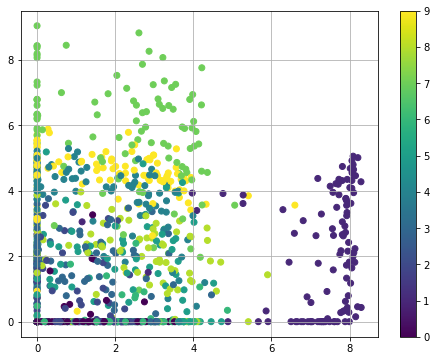

In [84]:
x_sample, y_sample = mnist.test.next_batch(1000)
print(x_sample.shape)
z_mu = vae_cnn.transform(x_sample)
print(x_sample)
print(vae.transform(x_sample))

plt.clf()
plt.figure(figsize=(8, 6))
# print(z_mu[:,0], z_mu[:,1])
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_sample)
plt.colorbar()
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

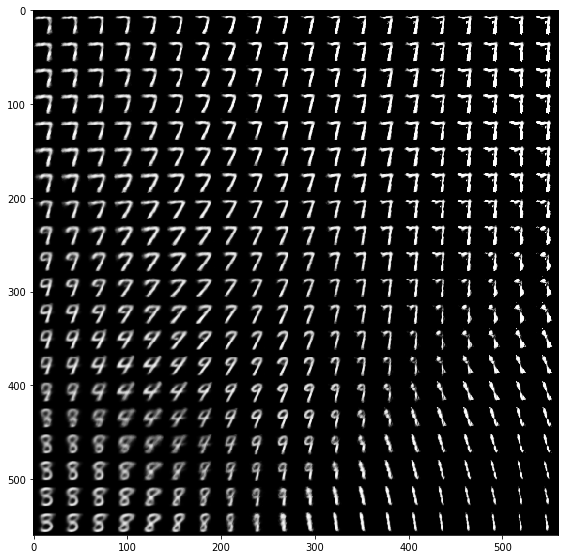

In [87]:
nx = ny = 20
x_values = np.linspace(0, 3, nx)
y_values = np.linspace(0, 3, ny)
canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
#         print(vae_2d.network_architecture["n_z"])
#         print(z_mu)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.clf()
plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()
plt.show()

In [90]:
from sklearn import svm

x_sample, y_sample = np.asarray(train_images[:10000]) / 256, train_labels[:10000]
x_test, y_test = np.asarray(test_images[:300]) / 256, test_labels[:300]
z_mu = vae_cnn.transform(x_sample)

clf = svm.SVC()
clf.fit(z_mu, y_sample)
print(clf.score(vae_cnn.transform(x_test), y_test))

0.49


In [91]:
import numpy as np
import tensorflow as tf
from data import *


tf.logging.set_verbosity(tf.logging.INFO)


class CNNVariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.

    This implementation uses probabilistic encoders and decoders using Gaussian
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.

    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """

    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus,
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])

        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and
        # corresponding optimizer
        self._create_loss_optimizer()

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)

    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and
        # (log) variance of Gaussian distribution in latent
        # space
        self._recognition_network()

        # Draw one sample z from Gaussian distribution
        eps = tf.random_normal((self.batch_size, self.n_z), 0, 1,
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean,
                        tf.multiply(tf.exp(self.z_log_sigma_sq / 2), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self._generator_network()

    def _initialize_weights(self, n_z, **kwargs):
        self.n_z = n_z

    def _recognition_network(self):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        self.input_layer = tf.reshape(self.x, [-1, 28, 28, 1])
        self.conv1 = tf.layers.conv2d(
            inputs=self.input_layer,
            filters=32,
            kernel_size=3,
            strides=2,
            padding="same",
            activation=tf.nn.relu
        )
        self.conv2 = tf.layers.conv2d(
            inputs=self.conv1,
            filters=64,
            kernel_size=3,
            strides=2,
            padding="same",
            activation=tf.nn.relu
        )
        self.conv2_flat = tf.reshape(self.conv2, [-1, 7 * 7 * 64])
        self.dense1 = tf.layers.dense(
            inputs=self.conv2_flat,
            units=16,
            activation=tf.nn.relu
        )
        self.z_mean = tf.layers.dense(
            inputs=self.dense1,
            units=self.n_z,
            activation=tf.nn.relu
        )
        self.z_log_sigma_sq = tf.layers.dense(
            inputs=self.dense1,
            units=self.n_z,
            activation=tf.nn.relu
        )

    # def _sample_z(self):
    #     noise = tf.random_normal(shape=(self.batch_size, self.n_z), mean=0., std=1.)
    #     return tf.add(self.z_mean, tf.matmul(tf.exp(self.z_log_sigma_sq / 2) * noise))

    def _generator_network(self):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        self.dense3 = tf.layers.dense(
            inputs=self.z,
            units=7 * 7 * 64,
            activation=tf.nn.relu
        )
        self.dense2_reshape = tf.reshape(self.dense3, [-1, 7, 7, 64])
        self.dconv1 = tf.layers.conv2d_transpose(
            inputs=self.dense2_reshape,
            filters=64,
            kernel_size=3,
            strides=2,
            padding="same",
            activation=tf.nn.relu)
        self.dconv2 = tf.layers.conv2d_transpose(
            inputs=self.dconv1,
            kernel_size=3,
            filters=32,
            strides=2,
            padding="same",
            activation=tf.nn.relu)
        self.dconv3 = tf.layers.conv2d_transpose(
            inputs=self.dconv2,
            kernel_size=3,
            filters=1,
            strides=1,
            padding="same",
            activation=tf.nn.sigmoid)
        self.x_reconstr_mean = tf.reshape(self.dconv3, [-1, 784])

    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1 - self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence
        #     between the distribution in latent space induced by the encoder on
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq
                                           - tf.square(self.z_mean)
                                           - tf.exp(self.z_log_sigma_sq), 1)
        
        tf.Print(reconstr_loss, [reconstr_loss], "Reconstruct loss:")
        tf.Print(latent_loss, [latent_loss], "Latent loss:")
        
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)  # average over batch
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, X):
        """Train model based on mini-batch of input data.

        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost),
                                  feed_dict={self.x: X})
        return cost

    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.

        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu})

    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X})


def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1):
    vae = CNNVariationalAutoencoder(network_architecture,
                                    learning_rate=learning_rate,
                                    batch_size=batch_size)
    # Training cycle
    n_samples = len(train_images)
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            batch_xs = np.asarray(train_images[i:i + batch_size], dtype=np.float32) / 256

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(avg_cost))
    return vae


network_architecture = {
    "n_input": 784, # MNIST data input (img shape: 28*28)
    "n_z": 20, # dimensionality of latent space
}

vae_cnn_20 = train(network_architecture, training_epochs=30)

/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 193.718608068
Epoch: 0002 cost= 160.189082667
Epoch: 0003 cost= 156.049518560
Epoch: 0004 cost= 153.930745570
Epoch: 0005 cost= 152.550186386
Epoch: 0006 cost= 151.322899017
Epoch: 0007 cost= 150.676132838
Epoch: 0008 cost= 150.021375771
Epoch: 0009 cost= 149.515994059
Epoch: 0010 cost= 149.087957052
Epoch: 0011 cost= 148.662941157
Epoch: 0012 cost= 148.248975271
Epoch: 0013 cost= 147.954904378
Epoch: 0014 cost= 147.820264002
Epoch: 0015 cost= 147.539934909
Epoch: 0016 cost= 147.388507462
Epoch: 0017 cost= 147.258790347
Epoch: 0018 cost= 146.886582667
Epoch: 0019 cost= 146.827448934
Epoch: 0020 cost= 146.810159327
Epoch: 0021 cost= 146.602983653
Epoch: 0022 cost= 146.572600098
Epoch: 0023 cost= 146.194526647
Epoch: 0024 cost= 146.188236618
Epoch: 0025 cost= 146.153725115
Epoch: 0026 cost= 145.944897423
Epoch: 0027 cost= 145.835816778
Epoch: 0028 cost= 145.804593239
Epoch: 0029 cost= 145.741756096
Epoch: 0030 cost= 145.710990079


In [92]:
from sklearn import svm

x_sample, y_sample = np.asarray(train_images[:10000]) / 256, train_labels[:10000]
x_test, y_test = np.asarray(test_images[:300]) / 256, test_labels[:300]
z_mu = vae_cnn_20.transform(x_sample)

clf = svm.SVC()
clf.fit(z_mu, y_sample)
print(clf.score(vae_cnn_20.transform(x_test), y_test))

0.9533333333333334


In [93]:
import numpy as np
import tensorflow as tf
from data import *

tf.logging.set_verbosity(tf.logging.INFO)


class ConvolutionalConditionalVariationalAutoEncoder(object):

    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus,
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        self.y = tf.placeholder(tf.uint8, [None, 1])

        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and
        # corresponding optimizer
        self._create_loss_optimizer()

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)

    def _create_network(self):
        self._initialize_weights(**self.network_architecture)

        self.input_label = tf.feature_column.input_layer(
            {"label": self.y},
            [tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_identity(
                key='label',
                num_buckets=10))]
        )

        self._recognition_network()

        eps = tf.random_normal((self.batch_size, self.n_z), 0, 1,
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean,
                        tf.multiply(tf.exp(self.z_log_sigma_sq / 2), eps))
        self._generator_network()

    def _initialize_weights(self, n_z, **kwargs):
        self.n_z = n_z

    def _recognition_network(self):
        self.input_layer = tf.reshape(self.x, [-1, 28, 28, 1])
        self.conv1 = tf.layers.conv2d(
            inputs=self.input_layer,
            filters=32,
            kernel_size=3,
            strides=2,
            padding="same",
            activation=tf.nn.relu
        )
        self.conv2 = tf.layers.conv2d(
            inputs=self.conv1,
            filters=64,
            kernel_size=3,
            strides=2,
            padding="same",
            activation=tf.nn.relu
        )
        self.conv2_flat = tf.reshape(self.conv2, [-1, 7 * 7 * 64])
        self.dense1 = tf.layers.dense(
            inputs=self.conv2_flat,
            units=20,
            activation=tf.nn.relu
        )
        self.dense_with_label = tf.concat([self.dense1, self.input_label], 1)
        # self.dense_with_label = tf.Print(self.dense_with_label, [tf.shape(self.dense_with_label)])
        self.z_mean = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=tf.nn.relu
        )
        self.z_log_sigma_sq = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=tf.nn.relu
        )

    def _generator_network(self):
        self.z_with_label = tf.concat([self.z, self.input_label], 1)
        self.dense3 = tf.layers.dense(
            inputs=self.z_with_label,
            units=7 * 7 * 64,
            activation=tf.nn.relu
        )
        self.dense2_reshape = tf.reshape(self.dense3, [-1, 7, 7, 64])
        self.dconv1 = tf.layers.conv2d_transpose(
            inputs=self.dense2_reshape,
            filters=64,
            kernel_size=3,
            strides=2,
            padding="same",
            activation=tf.nn.relu)
        self.dconv2 = tf.layers.conv2d_transpose(
            inputs=self.dconv1,
            kernel_size=3,
            filters=32,
            strides=2,
            padding="same",
            activation=tf.nn.relu)
        self.dconv3 = tf.layers.conv2d_transpose(
            inputs=self.dconv2,
            kernel_size=3,
            filters=1,
            strides=1,
            padding="same",
            activation=tf.nn.sigmoid)
        self.x_reconstr_mean = tf.reshape(self.dconv3, [-1, 784])

    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1 - self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence
        #     between the distribution in latent space induced by the encoder on
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq
                                           - tf.square(self.z_mean)
                                           - tf.exp(self.z_log_sigma_sq), 1)

        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)  # average over batch
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, X, y):
        """Train model based on mini-batch of input data.

        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost),
                                  feed_dict={self.x: X, self.y: y.reshape([-1, 1])})
        return cost

    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.

        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu})

    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X})


def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1):
    vae = ConvolutionalConditionalVariationalAutoEncoder(network_architecture,
                                                         learning_rate=learning_rate,
                                                         batch_size=batch_size)
    # Training cycle
    n_samples = len(train_images)
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            batch_features = np.asarray(train_images[i:i + batch_size], dtype=np.float32) / 256
            batch_label = np.asarray(train_labels[i:i + batch_size], dtype=np.uint8)

            # Fit training using batch data
            cost = vae.partial_fit(batch_features, batch_label)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "cost=", "{:.9f}".format(avg_cost))
    return vae


network_architecture = {
    "n_input": 784,  # MNIST data input (img shape: 28*28)
    "n_z": 2,  # dimensionality of latent space
}

cvae_2d = train(network_architecture, training_epochs=30)

/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 184.889392929
Epoch: 0002 cost= 157.628693644
Epoch: 0003 cost= 155.766963323
Epoch: 0004 cost= 154.960076904
Epoch: 0005 cost= 154.428345591
Epoch: 0006 cost= 154.097110189
Epoch: 0007 cost= 153.926915894
Epoch: 0008 cost= 153.696245244
Epoch: 0009 cost= 153.459479548
Epoch: 0010 cost= 153.238910726
Epoch: 0011 cost= 153.229529126
Epoch: 0012 cost= 153.198592631
Epoch: 0013 cost= 153.039378637
Epoch: 0014 cost= 152.929300690
Epoch: 0015 cost= 152.916422831
Epoch: 0016 cost= 152.857313538
Epoch: 0017 cost= 152.793756434
Epoch: 0018 cost= 152.818704096
Epoch: 0019 cost= 152.699842555
Epoch: 0020 cost= 152.689930191
Epoch: 0021 cost= 152.702787959
Epoch: 0022 cost= 152.661882248
Epoch: 0023 cost= 152.599501750
Epoch: 0024 cost= 152.481881790
Epoch: 0025 cost= 152.589481621
Epoch: 0026 cost= 152.542810872
Epoch: 0027 cost= 152.438644002
Epoch: 0028 cost= 152.399122874
Epoch: 0029 cost= 152.471954117
Epoch: 0030 cost= 152.434961955


In [94]:
x_sample, y_sample = mnist.test.next_batch(1000)
print(x_sample.shape)
z_mu = vae_cnn.transform(x_sample)
print(x_sample)
print(vae.transform(x_sample))

plt.clf()
plt.figure(figsize=(8, 6))
# print(z_mu[:,0], z_mu[:,1])
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_sample)
plt.colorbar()
plt.grid()
plt.show()

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_16' with dtype uint8 and shape [?,1]
	 [[Node: Placeholder_16 = Placeholder[dtype=DT_UINT8, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_16', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-93-8e15d33307ef>", line 215, in <module>
    cvae_2d = train(network_architecture, training_epochs=30)
  File "<ipython-input-93-8e15d33307ef>", line 188, in train
    batch_size=batch_size)
  File "<ipython-input-93-8e15d33307ef>", line 19, in __init__
    self.y = tf.placeholder(tf.uint8, [None, 1])
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1808, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4848, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_16' with dtype uint8 and shape [?,1]
	 [[Node: Placeholder_16 = Placeholder[dtype=DT_UINT8, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [95]:
import numpy as np
import tensorflow as tf
from data import *

tf.logging.set_verbosity(tf.logging.INFO)


class ConvolutionalConditionalVariationalAutoEncoder(object):

    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus,
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        self.y = tf.placeholder(tf.uint8, [None, 1])

        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and
        # corresponding optimizer
        self._create_loss_optimizer()

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)

    def _create_network(self):
        self._initialize_weights(**self.network_architecture)

        self.input_label = tf.feature_column.input_layer(
            {"label": self.y},
            [tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_identity(
                key='label',
                num_buckets=10))]
        )

        self._recognition_network()

        eps = tf.random_normal((self.batch_size, self.n_z), 0, 1,
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean,
                        tf.multiply(tf.exp(self.z_log_sigma_sq / 2), eps))
        self._generator_network()

    def _initialize_weights(self, n_z, **kwargs):
        self.n_z = n_z

    def _recognition_network(self):
        self.input_layer = tf.reshape(self.x, [-1, 28, 28, 1])
        self.conv1 = tf.layers.conv2d(
            inputs=self.input_layer,
            filters=32,
            kernel_size=3,
            strides=2,
            padding="same",
            activation=tf.nn.relu
        )
        self.conv2 = tf.layers.conv2d(
            inputs=self.conv1,
            filters=64,
            kernel_size=3,
            strides=2,
            padding="same",
            activation=tf.nn.relu
        )
        self.conv2_flat = tf.reshape(self.conv2, [-1, 7 * 7 * 64])
        self.dense1 = tf.layers.dense(
            inputs=self.conv2_flat,
            units=20,
            activation=tf.nn.relu
        )
        self.dense_with_label = tf.concat([self.dense1, self.input_label], 1)
        # self.dense_with_label = tf.Print(self.dense_with_label, [tf.shape(self.dense_with_label)])
        self.z_mean = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=tf.nn.relu
        )
        self.z_log_sigma_sq = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=tf.nn.relu
        )

    def _generator_network(self):
        self.z_with_label = tf.concat([self.z, self.input_label], 1)
        self.dense3 = tf.layers.dense(
            inputs=self.z_with_label,
            units=7 * 7 * 64,
            activation=tf.nn.relu
        )
        self.dense2_reshape = tf.reshape(self.dense3, [-1, 7, 7, 64])
        self.dconv1 = tf.layers.conv2d_transpose(
            inputs=self.dense2_reshape,
            filters=64,
            kernel_size=3,
            strides=2,
            padding="same",
            activation=tf.nn.relu)
        self.dconv2 = tf.layers.conv2d_transpose(
            inputs=self.dconv1,
            kernel_size=3,
            filters=32,
            strides=2,
            padding="same",
            activation=tf.nn.relu)
        self.dconv3 = tf.layers.conv2d_transpose(
            inputs=self.dconv2,
            kernel_size=3,
            filters=1,
            strides=1,
            padding="same",
            activation=tf.nn.sigmoid)
        self.x_reconstr_mean = tf.reshape(self.dconv3, [-1, 784])

    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1 - self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence
        #     between the distribution in latent space induced by the encoder on
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq
                                           - tf.square(self.z_mean)
                                           - tf.exp(self.z_log_sigma_sq), 1)

        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)  # average over batch
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, X, y):
        """Train model based on mini-batch of input data.

        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost),
                                  feed_dict={self.x: X, self.y: y.reshape([-1, 1])})
        return cost

    def transform(self, X, y):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X, self.y: y.reshape([-1, 1])})

    def generate(self, y, z_mu=None):
        """ Generate data by sampling from latent space.

        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu, self.y: y.reshape([-1, 1])})

    def reconstruct(self, X, y):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X, self.y: y.reshape([-1, 1])})


def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1):
    vae = ConvolutionalConditionalVariationalAutoEncoder(network_architecture,
                                                         learning_rate=learning_rate,
                                                         batch_size=batch_size)
    # Training cycle
    n_samples = len(train_images)
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            batch_features = np.asarray(train_images[i:i + batch_size], dtype=np.float32) / 256
            batch_label = np.asarray(train_labels[i:i + batch_size], dtype=np.uint8)

            # Fit training using batch data
            cost = vae.partial_fit(batch_features, batch_label)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "cost=", "{:.9f}".format(avg_cost))
    return vae


network_architecture = {
    "n_input": 784,  # MNIST data input (img shape: 28*28)
    "n_z": 2,  # dimensionality of latent space
}

cvae_2d = train(network_architecture, training_epochs=30)


/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 187.007458725
Epoch: 0002 cost= 161.269487000
Epoch: 0003 cost= 159.972835286
Epoch: 0004 cost= 159.425099284
Epoch: 0005 cost= 159.120983022
Epoch: 0006 cost= 158.835680669
Epoch: 0007 cost= 158.620614268
Epoch: 0008 cost= 158.479953384
Epoch: 0009 cost= 158.240544713
Epoch: 0010 cost= 158.232851639
Epoch: 0011 cost= 158.161875127
Epoch: 0012 cost= 158.041112111
Epoch: 0013 cost= 157.969009145
Epoch: 0014 cost= 157.955150223
Epoch: 0015 cost= 157.842450307
Epoch: 0016 cost= 157.870444438
Epoch: 0017 cost= 157.740405935
Epoch: 0018 cost= 157.191004003
Epoch: 0019 cost= 154.033442027
Epoch: 0020 cost= 153.445928802
Epoch: 0021 cost= 153.312231623
Epoch: 0022 cost= 152.983479207
Epoch: 0023 cost= 152.874248021
Epoch: 0024 cost= 152.838976517
Epoch: 0025 cost= 152.692626444
Epoch: 0026 cost= 152.586747742
Epoch: 0027 cost= 152.623451436
Epoch: 0028 cost= 152.610545680
Epoch: 0029 cost= 152.545273819
Epoch: 0030 cost= 152.501044566


In [1]:
import numpy as np
import tensorflow as tf
import time

import mnist

tf.logging.set_verbosity(tf.logging.INFO)


class VariationalAutoEncoder(object):

    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # tf Graph input
        self._initialize_network(**self.network_architecture)
        self.x = tf.placeholder(tf.float32, shape=[None, self.image_width * self.image_width], name="input")

        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and
        # corresponding optimizer
        self._create_loss_optimizer()

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.writer = tf.summary.FileWriter(".", self.sess.graph)
        self.sess.run(init)

    def _create_network(self):
        # Use recognition network to determine mean and
        # (log) variance of Gaussian distribution in latent space
        self._recognition_network()

        # Draw one sample z from Gaussian distribution
        eps = tf.random_normal((self.batch_size, self.n_z), 0, 1, dtype=tf.float32)
        # z = mu + sigma * epsilon
        self.z = tf.add(self.z_mean, tf.multiply(tf.exp(self.z_log_sigma_sq / 2), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self._generator_network()

    def _initialize_network(self, n_z, n_width, n_hidden_units, n_layers, **kwargs):
        self.n_z = n_z
        self.image_width = n_width
        self.n_hidden_units = n_hidden_units
        self.n_layers = n_layers
        self.input_layers = [None for i in range(self.n_layers + 1)]
        self.output_layers = [None for i in range(self.n_layers + 1)]

    def _recognition_network(self):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        self.input_layers[0] = tf.layers.flatten(self.x)
        for i in range(1, self.n_layers + 1):
            self.input_layers[i] = tf.layers.dense(
                inputs=self.input_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus
            )
        self.z_mean = tf.layers.dense(
            inputs=self.input_layers[-1],
            units=self.n_z,
            activation=None,
            name="z_mean"
        )
        self.z_log_sigma_sq = tf.layers.dense(
            inputs=self.input_layers[-1],
            units=self.n_z,
            activation=None,
            name="z_log_sigma_sq"
        )

    def _generator_network(self):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        self.output_layers[0] = self.z
        for i in range(1, self.n_layers + 1):
            self.output_layers[i] = tf.layers.dense(
                inputs=self.output_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus
            )
        self.x_reconstr_mean = tf.layers.dense(
            inputs=self.output_layers[-1],
            units=self.image_width * self.image_width,
            activation=tf.nn.sigmoid)

    def _create_loss_optimizer(self):
        with tf.name_scope("cost"):
            # The loss is composed of two terms:
            # 1.) The reconstruction loss (the negative log probability
            #     of the input under the reconstructed Bernoulli distribution
            #     induced by the decoder in the data space).
            #     This can be interpreted as the number of "nats" required
            #     for reconstructing the input when the activation in latent
            #     is given.
            # Adding 1e-10 to avoid evaluation of log(0.0)
            reconstr_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                               + (1 - self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean), 1)

            # 2.) The latent loss, which is defined as the KL divergence
            #     between the distribution in latent space induced by the encoder on
            #     the data and some prior. This acts as a kind of regularizer.
            #     This can be interpreted as the number of "nats" required
            #     for transmitting the the latent space distribution given
            #     the prior.
            latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq - tf.square(self.z_mean)
                                               - tf.exp(self.z_log_sigma_sq), 1)

            self.cost = tf.reduce_mean(reconstr_loss + latent_loss, name="total_cost")  # average over batch
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, X):
        """
        Train model based on mini-batch of input data.
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), feed_dict={self.x: X})
        return cost

    def transform(self, X):
        """
        Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, z_mu=None):
        """
        Generate data by sampling from latent space.
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu})

    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X})


def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1, saving_step=10):
    model_name = cls.__name__ + "." + ''.join(filter(lambda x: x.isdigit(), datetime.now().isoformat()))

    vae = VariationalAutoEncoder(network_architecture,
              learning_rate=learning_rate,
              batch_size=batch_size)
    # Training cycle
    train_x, train_y = mnist.train_32_flat_labeled()
    n_samples = train_x.shape[0]
    w = network_architecture["n_width"]

    t0 = time.time()
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            batch_xs = train_x[i:i + batch_size].reshape((-1, w * w))
            batch_xs = batch_xs.reshape((-1, w * w))

            cost = vae.partial_fit(batch_xs)
            avg_cost += np.mean(cost) / n_samples * batch_size
        t1 = time.time()

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "Cost:", "%.9f" % avg_cost,
                  "Time:", "%.3f" % (t1 - t0))
        if epoch % saving_step == 0:
            vae.save("tmp/" + model_name + ".step%d" % epoch)

    return vae
    

def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1):
    vae = VariationalAutoEncoder(network_architecture,
                                 learning_rate=learning_rate,
                                 batch_size=batch_size)
    # Training cycle
    _, train_y = mnist.train()
    train_x = mnist.train_32()
    n_samples = train_x.shape[0]
    w = network_architecture["n_width"]

    t0 = time.time()
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            # print(i)
            batch_xs = np.asarray(train_x[i:i + batch_size], dtype=np.float32) / 256
            batch_xs = batch_xs.reshape((-1, w * w))

            cost = vae.partial_fit(batch_xs)
            avg_cost += cost / n_samples * batch_size
        t1 = time.time()

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "Cost:", "{:.9f}".format(avg_cost),
                  "Time:", "%.3f" % (t1 - t0))
    return vae


network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 2
}

vae = train(network_architecture, training_epochs=30)

Epoch: 0001 Cost: 222.122686183 Time: 5.992
Epoch: 0002 Cost: 173.759465841 Time: 11.856
Epoch: 0003 Cost: 161.862718964 Time: 17.716
Epoch: 0004 Cost: 156.892775574 Time: 23.571


KeyboardInterrupt: 